In [1]:
import numpy as np
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

W0407 13:35:53.375497 139978796984128 deprecation.py:323] From <ipython-input-2-8bf8ae5a5303>:2: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0407 13:35:53.376647 139978796984128 deprecation.py:323] From /home/direwolf/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0407 13:35:53.377656 139978796984128 deprecation.py:323] From /home/direwolf/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/base.py:252: _internal_retry.<locals>.wrap.<locals>.wrapped_fn (from tensorflow.contrib.learn.python.learn.datasets.base) is de

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz


W0407 13:37:22.862340 139978796984128 deprecation.py:323] From /home/direwolf/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:267: extract_labels (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.data to implement this functionality.
W0407 13:37:22.870351 139978796984128 deprecation.py:323] From /home/direwolf/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:110: dense_to_one_hot (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use tf.one_hot on tensors.


Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz


W0407 13:37:36.871203 139978796984128 deprecation.py:323] From /home/direwolf/anaconda3/lib/python3.7/site-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
inputs_ = tf.placeholder(tf.float32,[None,28,28,1])
targets_ = tf.placeholder(tf.float32,[None,28,28,1])

In [4]:
def lrelu(x,alpha=0.1):
    return tf.maximum(alpha*x,x)

In [5]:
### Encoder
with tf.name_scope('en-convolutions'):
    conv1 = tf.layers.conv2d(inputs_,filters=32,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv1')
# Now 28x28x32
with tf.name_scope('en-pooling'):
    maxpool1 = tf.layers.max_pooling2d(conv1,pool_size=(2,2),strides=(2,2),name='pool1')
# Now 14x14x32
with tf.name_scope('en-convolutions'):
    conv2 = tf.layers.conv2d(maxpool1,filters=32,kernel_size=(3,3),strides=(1,1),padding='SAME',use_bias=True,activation=lrelu,name='conv2')
# Now 14x14x32
with tf.name_scope('encoding'):
    encoded = tf.layers.max_pooling2d(conv2,pool_size=(2,2),strides=(2,2),name='encoding')
# Now 7x7x32.
#latent space

W0407 13:37:37.465035 139978796984128 deprecation.py:323] From <ipython-input-5-7cb2532a43d3>:3: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0407 13:37:37.475243 139978796984128 deprecation.py:506] From /home/direwolf/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0407 13:37:37.953128 139978796984128 deprecation.py:323] From <ipython-input-5-7cb2532a43d3>:6: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.


In [6]:
### Decoder
with tf.name_scope('decoder'):
    conv3 = tf.layers.conv2d(encoded,filters=32,kernel_size=(3,3),strides=(1,1),name='conv3',padding='SAME',use_bias=True,activation=lrelu)
#Now 7x7x32        
    upsample1 = tf.layers.conv2d_transpose(conv3,filters=32,kernel_size=3,padding='same',strides=2,name='upsample1')
# Now 14x14x32
    upsample2 = tf.layers.conv2d_transpose(upsample1,filters=32,kernel_size=3,padding='same',strides=2,name='upsample2')
# Now 28x28x32
    logits = tf.layers.conv2d(upsample2,filters=1,kernel_size=(3,3),strides=(1,1),name='logits',padding='SAME',use_bias=True)
#Now 28x28x1
# Pass logits through sigmoid to get reconstructed image
    decoded = tf.sigmoid(logits,name='recon')

W0407 13:37:38.170778 139978796984128 deprecation.py:323] From <ipython-input-6-a6a2d648ef42>:5: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.


In [7]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=targets_)

learning_rate=tf.placeholder(tf.float32)
cost = tf.reduce_mean(loss)  #cost
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost) #optimizer

W0407 13:37:38.957334 139978796984128 deprecation.py:323] From /home/direwolf/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch: 1/25... Training loss: 0.4986 Validation loss: 0.4976


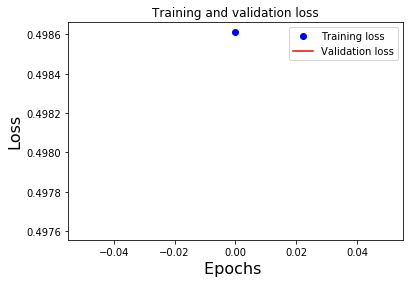

<Figure size 432x288 with 0 Axes>

Epoch: 2/25... Training loss: 0.3586 Validation loss: 0.3572


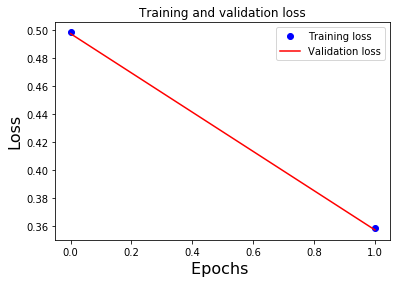

<Figure size 432x288 with 0 Axes>

Epoch: 3/25... Training loss: 0.2108 Validation loss: 0.2107


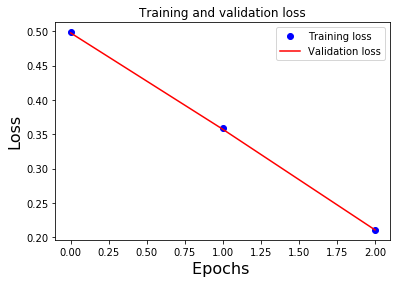

<Figure size 432x288 with 0 Axes>

Epoch: 4/25... Training loss: 0.1663 Validation loss: 0.1684


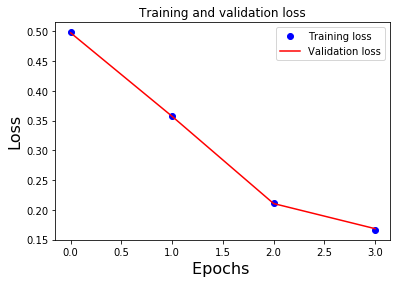

<Figure size 432x288 with 0 Axes>

Epoch: 5/25... Training loss: 0.1632 Validation loss: 0.1644


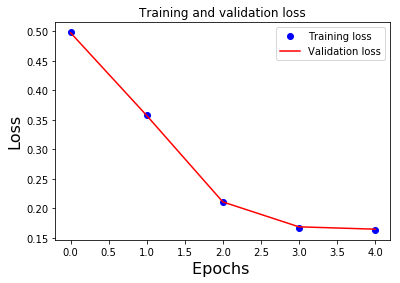

<Figure size 432x288 with 0 Axes>

Epoch: 6/25... Training loss: 0.1452 Validation loss: 0.1483


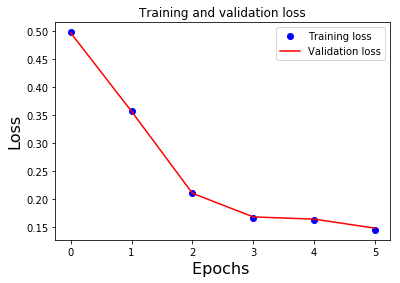

<Figure size 432x288 with 0 Axes>

Epoch: 7/25... Training loss: 0.1436 Validation loss: 0.1431


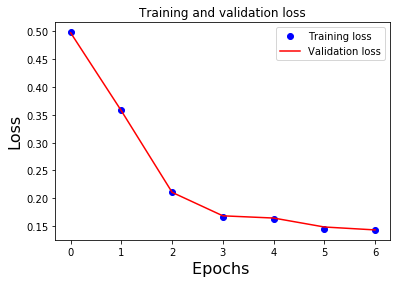

<Figure size 432x288 with 0 Axes>

Epoch: 8/25... Training loss: 0.1385 Validation loss: 0.1386


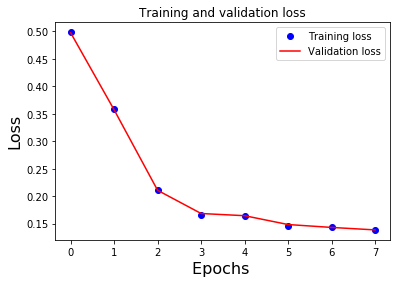

<Figure size 432x288 with 0 Axes>

Epoch: 9/25... Training loss: 0.1288 Validation loss: 0.1323


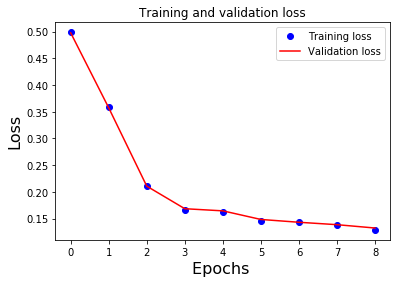

<Figure size 432x288 with 0 Axes>

Epoch: 10/25... Training loss: 0.1245 Validation loss: 0.1252


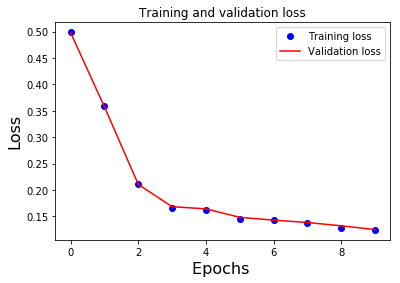

<Figure size 432x288 with 0 Axes>

Epoch: 11/25... Training loss: 0.1203 Validation loss: 0.1197


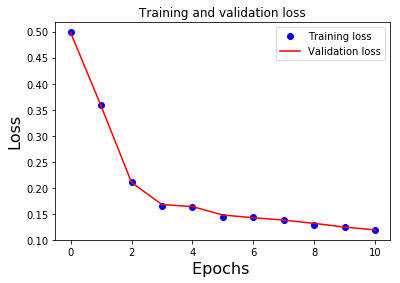

<Figure size 432x288 with 0 Axes>

Epoch: 12/25... Training loss: 0.1219 Validation loss: 0.1222


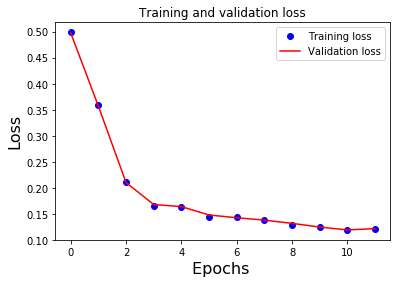

<Figure size 432x288 with 0 Axes>

Epoch: 13/25... Training loss: 0.1255 Validation loss: 0.1255


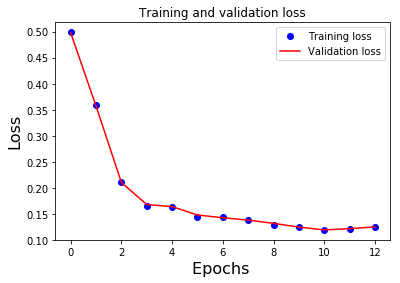

<Figure size 432x288 with 0 Axes>

Epoch: 14/25... Training loss: 0.1269 Validation loss: 0.1242


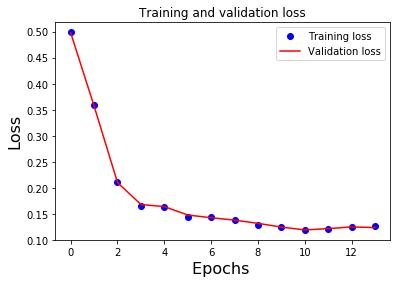

<Figure size 432x288 with 0 Axes>

Epoch: 15/25... Training loss: 0.1191 Validation loss: 0.1196


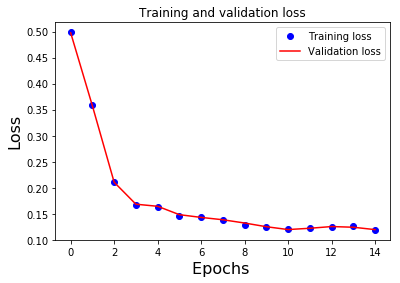

<Figure size 432x288 with 0 Axes>

Epoch: 16/25... Training loss: 0.1192 Validation loss: 0.1213


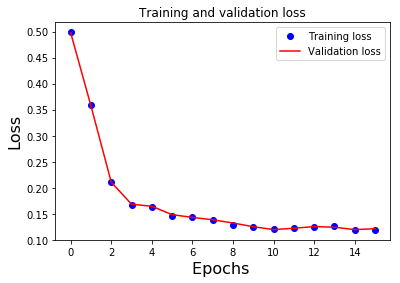

<Figure size 432x288 with 0 Axes>

Epoch: 17/25... Training loss: 0.1199 Validation loss: 0.1205


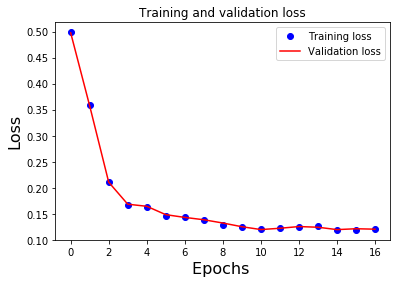

<Figure size 432x288 with 0 Axes>

Epoch: 18/25... Training loss: 0.1192 Validation loss: 0.1194


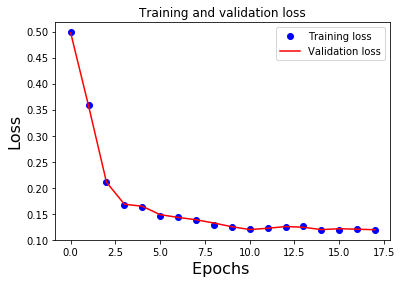

<Figure size 432x288 with 0 Axes>

Epoch: 19/25... Training loss: 0.1203 Validation loss: 0.1202


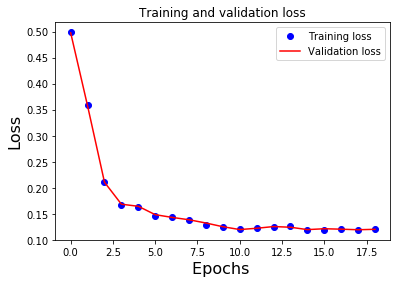

<Figure size 432x288 with 0 Axes>

Epoch: 20/25... Training loss: 0.1230 Validation loss: 0.1212


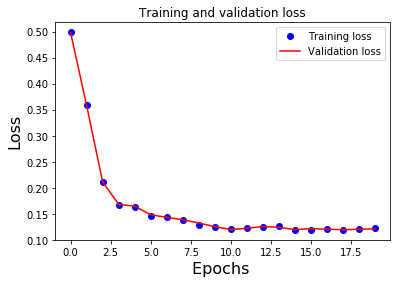

<Figure size 432x288 with 0 Axes>

Epoch: 21/25... Training loss: 0.1169 Validation loss: 0.1164


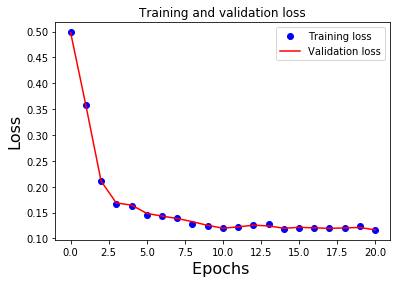

<Figure size 432x288 with 0 Axes>

Epoch: 22/25... Training loss: 0.1204 Validation loss: 0.1229


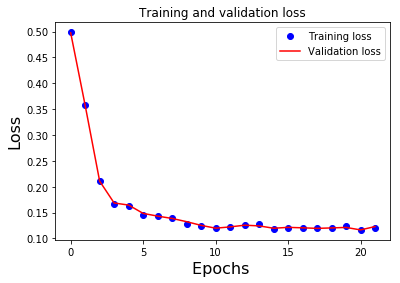

<Figure size 432x288 with 0 Axes>

Epoch: 23/25... Training loss: 0.1198 Validation loss: 0.1217


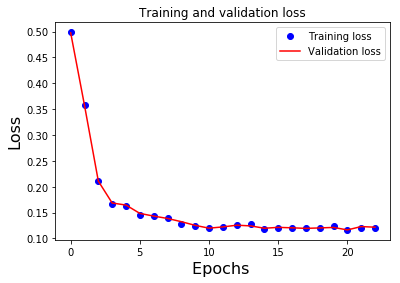

<Figure size 432x288 with 0 Axes>

Epoch: 24/25... Training loss: 0.1209 Validation loss: 0.1209


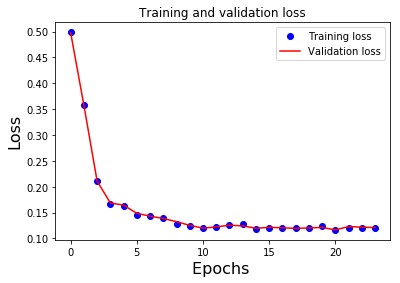

<Figure size 432x288 with 0 Axes>

Epoch: 25/25... Training loss: 0.1152 Validation loss: 0.1149


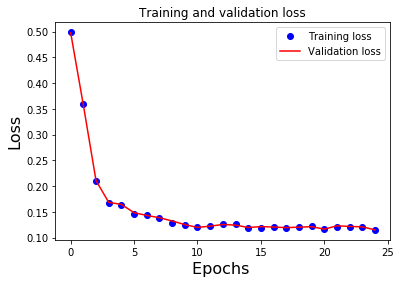

<Figure size 432x288 with 0 Axes>

Original Images


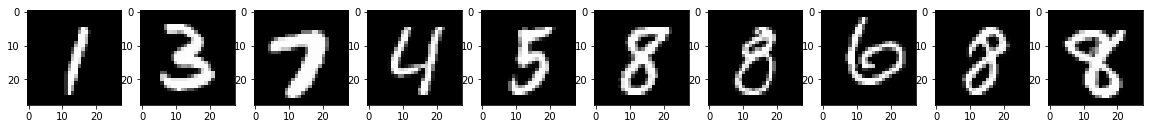

Noisy Images


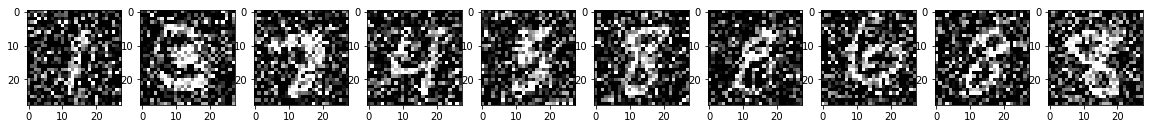

Reconstruction of Noisy Images


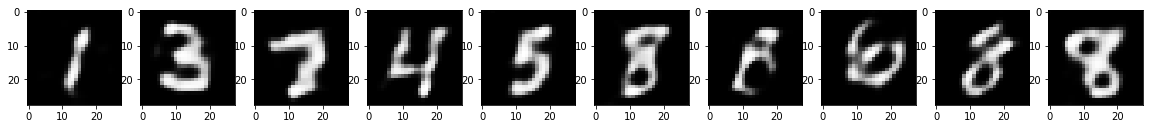

In [8]:
# Training

sess = tf.Session()
#tf.reset_default_graph()

saver = tf.train.Saver()
loss = []
valid_loss = []



display_step = 1
epochs = 25
batch_size = 64
#lr=[1e-3/(2**(i//5))for i in range(epochs)]
lr=1e-5
sess.run(tf.global_variables_initializer())
writer = tf.summary.FileWriter('./graphs', sess.graph)
for e in range(epochs):
    total_batch = int(mnist.train.num_examples/batch_size)
    for ibatch in range(total_batch):
        batch_x = mnist.train.next_batch(batch_size)
        batch_test_x= mnist.test.next_batch(batch_size)
        imgs_test = batch_x[0].reshape((-1, 28, 28, 1))
        noise_factor = 0.5
        x_test_noisy = imgs_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs_test.shape) 
        x_test_noisy = np.clip(x_test_noisy, 0., 1.)
        imgs = batch_x[0].reshape((-1, 28, 28, 1))
        x_train_noisy = imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape) 
        x_train_noisy = np.clip(x_train_noisy, 0., 1.)
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: x_train_noisy,
                                                         targets_: imgs,learning_rate:lr})
      
        batch_cost_test = sess.run(cost, feed_dict={inputs_: x_test_noisy,
                                                         targets_: imgs_test})
    if (e+1) % display_step == 0:
        print("Epoch: {}/{}...".format(e+1, epochs),
                  "Training loss: {:.4f}".format(batch_cost),
                 "Validation loss: {:.4f}".format(batch_cost_test))
   
    loss.append(batch_cost)
    valid_loss.append(batch_cost_test)
    plt.plot(range(e+1), loss, 'bo', label='Training loss')
    plt.plot(range(e+1), valid_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.legend()
    plt.figure()
    plt.show()
    saver.save(sess, 'encode_model') 

batch_x= mnist.test.next_batch(10)
imgs = batch_x[0].reshape((-1, 28, 28, 1))
noise_factor = 0.5
x_test_noisy = imgs + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=imgs.shape) 
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
recon_img = sess.run([decoded], feed_dict={inputs_: x_test_noisy})[0]
plt.figure(figsize=(20, 4))
plt.title('Reconstructed Images')
print("Original Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(imgs[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Noisy Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test_noisy[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(recon_img[i, ..., 0], cmap='gray')    
plt.show()    

writer.close()

sess.close()